# Generate Statistics From BQ Via Dataflow

This notebook has example code to be able to generate TFDV statistics of input data directly from BigQuery via Vertex pipelines. 

It uses the [DataflowPythonJobOp](https://cloud.google.com/vertex-ai/docs/pipelines/dataflow-component) component to launch a Dataflow job through Vertex Pipelines, using a Beam script that has been uploaded to Google Cloud Storage.

The [visualise_statistics](https://github.com/GoogleCloudPlatform/vertex-pipelines-end-to-end-samples/blob/main/pipelines/kfp_components/tfdv/visualise_statistics.py) function is used to visualise the resulting statistics.

In [ ]:
# Install required libraries to submit pipeline
# !pip install kfp==1.8.17 google-cloud-pipeline-components==1.0.37 google-cloud-aiplatform

In [ ]:
from typing import NamedTuple

import kfp
from google.cloud import aiplatform
from kfp.v2 import dsl
from kfp.v2.dsl import (Artifact, Output, component)
from google_cloud_pipeline_components.v1.dataflow import DataflowPythonJobOp
from google_cloud_pipeline_components.v1.wait_gcp_resources import WaitGcpResourcesOp

In [ ]:
bq_project_id="<PROJECT_ID>"
query='SELECT * FROM `<PROJECT_ID>.<DATASET_ID>.<TABLE_ID>`'
gcs_temp_location="gs://<GCS_BUCKET>/temp"
gcs_staging_location="gs://<GCS_BUCKET>/staging"
subnetwork="<SUBNETWORK>"
pipeline_root="gs://<GCS_ROOT_BUCKET>"
location="europe-west1"
runner="DataflowRunner"
service_account="<SERVICE_ACCOUNT"
python_file_path="gs://<GCS_BUCKET>/generate_statistics_from_bq.py"
requirements_file_path="gs://<GCS_BUCKET>/requirements.txt"
setup_file_path="gs://<GCS_BUCKET>/setup.py"
statistics_path="gs://<GCS_BUCKET>/statistics"

In [ ]:
%%writefile generate_statistics_from_bq.py

import inspect
import logging
import os
import apache_beam as beam
import pyarrow
import numpy as np
import tensorflow_data_validation as tfdv
import tensorflow_metadata
import tfx_bsl
from tensorflow_data_validation import constants
from tensorflow_data_validation import types
from tensorflow_data_validation.arrow import decoded_examples_to_arrow
from tfx_bsl.coders import batch_util
from apache_beam.options.pipeline_options import (
    PipelineOptions,
    GoogleCloudOptions,
    StandardOptions,
    SetupOptions,
    WorkerOptions,
    DebugOptions,
)
import argparse

logging.getLogger().setLevel(logging.INFO)

def row_to_nparray(row):
    return {k: np.asarray([v]) for k,v in row.items()}
        
def run(argv=None):
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--bq_project_id',
                      dest='bq_project_id',
                      help='Project to run BQ job.')
    
    parser.add_argument('--query',
                      dest='query',
                      help='Query to process data.')
    
    parser.add_argument('--processing_location',
                      dest='processing_location',
                      help='GCS bucket for processing job.')
    
    parser.add_argument('--statistics_path',
                      dest='statistics_path',
                      help='Path to write statistics to.')
    
    known_args, pipeline_args = parser.parse_known_args(argv)

    pipeline_options = PipelineOptions()
    debug_options = pipeline_options.view_as(DebugOptions)
    google_cloud_options = pipeline_options.view_as(GoogleCloudOptions)
    setup_options = pipeline_options.view_as(SetupOptions)
    standard_options = pipeline_options.view_as(StandardOptions)
    setup_options.save_main_session = True
    worker_options = pipeline_options.view_as(WorkerOptions)
    worker_options.use_public_ips = True

    logging.info(f"Saving statistics to: {known_args.statistics_path}")

    with beam.Pipeline(options=pipeline_options) as p:

        (p | "Read input from BigQuery" >> beam.io.ReadFromBigQuery(
            project=known_args.bq_project_id, 
            query=known_args.query, 
            use_standard_sql=True, 
            flatten_results=False,
            gcs_location=known_args.processing_location,)
            | 'to dict' >> beam.Map(row_to_nparray)  
            | "BatchBeamExamples" >> beam.BatchElements(**batch_util.GetBatchElementsKwargs(batch_size=1000))
            | "DecodeExamplesToRecordBatch" >> beam.Map(lambda x: decoded_examples_to_arrow.DecodedExamplesToRecordBatch(x))
            | 'tdfv' >> tfdv.GenerateStatistics()
            | 'WriteStatsOutput' >> tfdv.WriteStatisticsToTFRecord(known_args.statistics_path)
        )
        
if __name__ == '__main__':
    run()

In [ ]:
%%writefile requirments.txt

tensorflow-data-validation==1.6.0
tensorflow-metadata==1.6.0
apache-beam==2.38.0
numpy==1.20.3
pyarrow==5.0.0
tfx-bsl==1.6.0

In [ ]:
%%writefile setup.py

import setuptools
setuptools.setup(
    install_requires=[
        'tensorflow-data-validation==1.6.0',
        'numpy==1.20.3',
        'pyarrow==5.0.0',
        'tfx-bsl==1.6.0'],
    packages=setuptools.find_packages()
)

In [ ]:
!gsutil cp generate_statistics_from_bq.py $python_file_path
!gsutil cp setup.py $setup_file_path
!gsutil cp requirements.txt $requirements_file_path

In [ ]:
from kfp.v2.dsl import Output, component, HTML

@component(base_image="python:3.7", packages_to_install=["tensorflow-data-validation==1.6.0"])
def visualise_statistics(
    statistics_path: str,
    view: Output[HTML],
    statistics_name: str = "",
) -> None:
    """
    Generate an html artifact allowing to visualize the data statistics.
    Args:
        statistics (str): Generated protobuf statistics from TFDV.
        view (Output[Artifact]): Output artifact to store the visualised statistics
            as html file.
        statistics_name (str): Optional. Name of the statistics. Defaults to ""
    Returns:
        None
    """
    import tensorflow_data_validation as tfdv
    from tensorflow_data_validation.utils.display_util import (
        get_statistics_html,
    )

    # load stats
    stats = tfdv.load_statistics(input_path=statistics_path)

    # create html content
    html = get_statistics_html(
        lhs_statistics=stats,
        lhs_name=statistics_name,
    )

    # ensure view is stored as html (this will set content-type to text/html)
    if not view.path.endswith(".html"):
        view.path += ".html"

    # write html to output file
    with open(view.path, "w") as f:
        f.write(html)

In [ ]:
@kfp.dsl.pipeline(name="generate-statistics-from-bq-table", pipeline_root=pipeline_root)
def pipeline(
):
    dataflow_python_op = DataflowPythonJobOp(
        project=bq_project_id,
        location=location,
        python_module_path=python_file_path,
        requirements_file_path=requirements_file_path,
        temp_location=gcs_temp_location,
        args=["--runner", runner,
              "--bq_project_id", bq_project_id, 
              "--query", query,
              "--processing_location", gcs_temp_location,
              "--statistics_path", statistics_path,
              "--setup_file", setup_file_path,
              "--service_account_email", service_account,
              "--subnetwork", subnetwork],
    )

    dataflow_wait_op = WaitGcpResourcesOp(
        gcp_resources=dataflow_python_op.outputs["gcp_resources"]
    )

    visualised_statistics_task = visualise_statistics(
            statistics_path=statistics_path, statistics_name="Data Statistics"
    ).set_display_name("Visualise data statistics").after(dataflow_wait_op)

In [ ]:
from kfp.v2 import compiler

compiler.Compiler().compile(
    pipeline_func=pipeline,
    package_path="generate_statistics_from_bq_table_pipeline.json",
)

In [ ]:
# Configure the pipeline
job = aiplatform.PipelineJob(
    display_name="generate-statistics-from-bq-table",
    template_path="generate_statistics_from_bq_table_pipeline.json",
    location=location,
    pipeline_root=pipeline_root,
    parameter_values={
    },
    enable_caching=False,
)

In [ ]:
# Run the job
job.submit(
    service_account=service_account)

Once the pipeline has successfully run, you can see the statistics in a link through the UI directly.

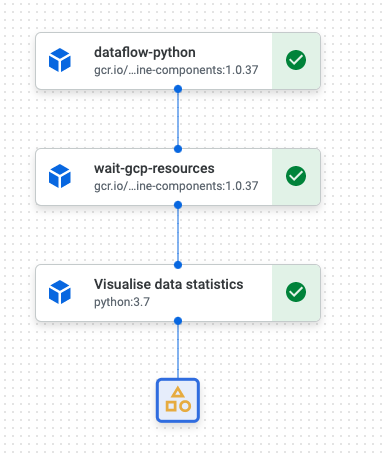

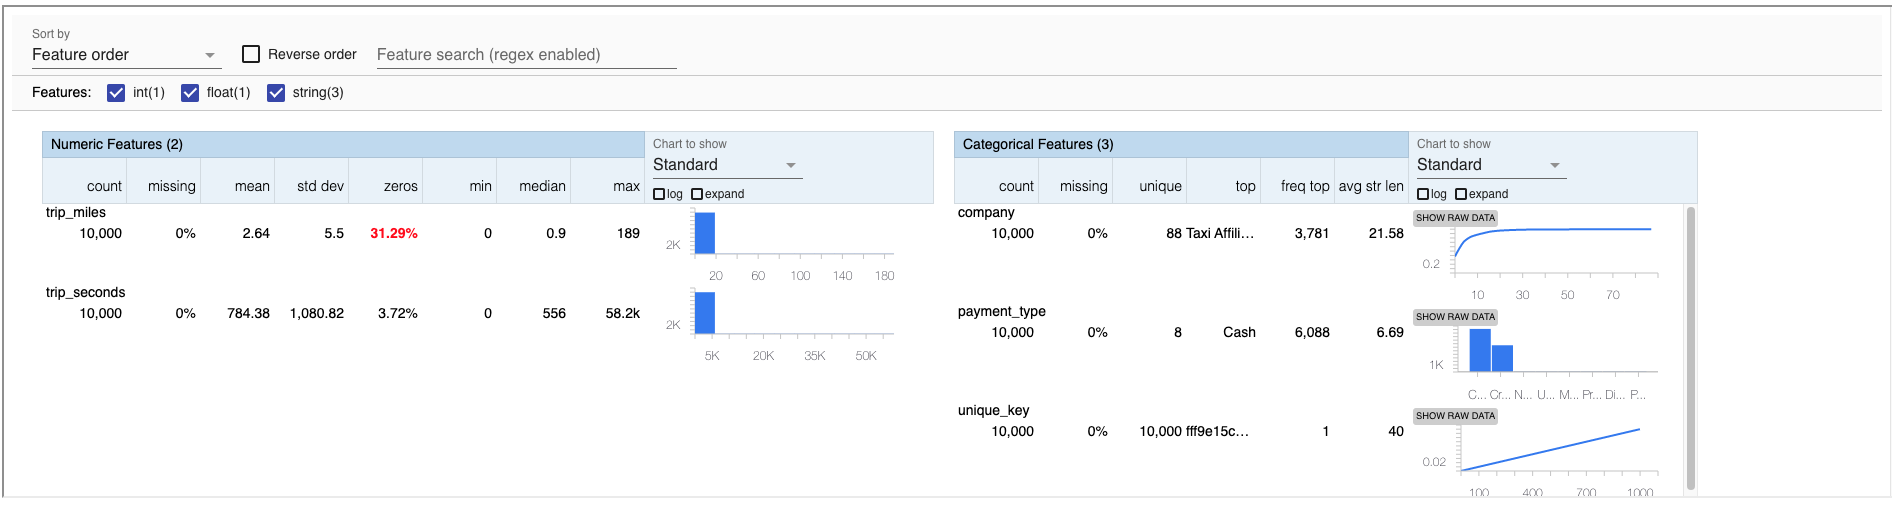